# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM, UnivariateBalance, imbalance
from util.fg_data import clean, get_data

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_palette('colorblind')
from datetime import datetime as dt

## Preprocessing

In [2]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   dist           18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [3]:
# df = pd.read_csv('../data/field_goals.csv', index_col=0)
# df.drop(['kicks','age','form'], axis=1, inplace=True)
# df.info()

## Variable of Interest

We filter for away kicks at altitude because only Denver home games are at altitude, so need to avoid biasing for Broncos kicker?

In [4]:
# T = 'iced'
# drop = []

T = 'altitude'
drop = ['turf']
# df[on] = df[on].astype(bool)

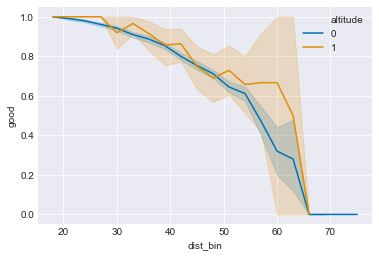

In [5]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue=T, data=df_)

In [6]:
print(df[T].value_counts())

0    18168
1      635
Name: altitude, dtype: int64


In [7]:
df

,good,dist,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,2000,17,22,0,10,1,0,0,1,0,1
2185,1,27,2000,17,22,0,10,1,0,0,1,0,1
4565,1,36,2000,17,26,0,13,0,0,1,0,0,5
8564,1,24,2000,17,16,0,16,1,0,0,1,1,1
8628,1,40,2000,17,16,0,16,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
862982,1,30,2019,3,18,0,0,0,0,0,0,0,1
865338,1,21,2019,3,18,0,11,0,0,0,0,0,2
868268,1,22,2019,3,6,0,7,1,0,0,1,0,1


## One-to-many CEM with weighted linear regression - relaxed on distance
## k-k CEM with linear regression - relaxed on distance
## One-to-many CEM with weighted t-test / z-test (for altitude only on long range kicks?)
## k-k CEM with t-test / z-test (as above)
## One-to-many with Bayesian difference of means (May not be possible with beta-binomial conjugacy) (as above)
## k-k CEM with Bayesian difference of means (as above)

### We setup our cem matcher which will calculate H (including bins and ranges) for imbalance calculations if it is not provided explicitly.

In [8]:
continuous = ['dist', 'year', 'seasons', 'temperature', 'wind', 'pressure']
cem = CEM(df, T, 'good', continuous)
# cem = CEM(df, T, 'good', continuous, H=5)

Calculating H, this may take a few minutes.
Unable to allocate 6.87 GiB for an array with shape (10, 10, 10, 10, 10, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', 'temperature', 'wind', 'away_game',
       'postseason', 'iced', 'turf', 'precipitation', 'pressure'],
      dtype='object')
Unable to allocate 11.1 GiB for an array with shape (11, 11, 11, 11, 11, 4, 4, 4, 4, 4, 9) and data type float64
11 11 11 Index(['dist', 'year', 'seasons', 'temperature', 'wind', 'away_game',
       'postseason', 'iced', 'turf', 'precipitation', 'pressure'],
      dtype='object')


### Else we can calculate the imbalance outside of the cem object, for a range of H's, for both the raw data and post-matched data.

Below is a base coarsening schema that we can relax or whatever as we see fit.

In [9]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 4, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 4, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [10]:
# Put this in the CEM class somewhere
# rows = []
# cont_bins = range(1,10)
# weights = cem.match(coarsening)
# for H in cont_bins:
#     # we use H bins for continuous variables when evaluating imbalance
#     original_imbalance, (bins, ranges) = imbalance(cem.data.drop('good', axis=1), T, continuous=continuous, H=H, retargs=True)
#     rows.append(pd.Series({'data':'raw', 'measure':original_imbalance, 'H': H}))
#     cem_imbalance = imbalance(cem.data.drop('good', axis=1).loc[weights>0, :], T, bins=bins, ranges=ranges) # same bins and ranges as raw data histogram
#     rows.append(pd.Series({'data':'CEM', 'measure':cem_imbalance, 'H': H}))
# imbalance = pd.DataFrame.from_records(rows)
# ax = sns.lineplot(x='H', y='measure', hue='data', data=imbalance, markers=True, style='data')
# ax.set_title('L1 score for different continuous binnings')

## L1 for depth>=1 and one-to-many

We can relax the coursening progressively on any number of covariates.

In [11]:
relax_on = [('dist', range(2,9), 'cut'),]
relaxed = cem.relax(coarsening, relax_on, 'l1')

100%|██████████| 7/7 [00:59<00:00,  8.49s/it]


In [12]:
relaxed.summary

,imbalance,measure,coarsening,bins,treatment_0,treatment_1
0,0.672151,l1,"{'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...",27648,4078,549
1,0.667124,l1,"{'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...",41472,3633,529
2,0.653372,l1,"{'dist': {'bins': 4, 'cut': 'cut'}, 'year': {'...",55296,3181,520
3,0.627670,l1,"{'dist': {'bins': 5, 'cut': 'cut'}, 'year': {'...",69120,2871,503
4,0.657328,l1,"{'dist': {'bins': 6, 'cut': 'cut'}, 'year': {'...",82944,2747,493
5,0.637236,l1,"{'dist': {'bins': 7, 'cut': 'cut'}, 'year': {'...",96768,2394,490
6,0.644727,l1,"{'dist': {'bins': 8, 'cut': 'cut'}, 'year': {'...",110592,2319,471


(<matplotlib.axes._subplots.AxesSubplot at 0x2bf4fe41288>,
    imbalance measure                                         coarsening  \
 0   0.672151      l1  {'dist': {'bins': 2, 'cut': 'cut'}, 'year': {'...   
 1   0.667124      l1  {'dist': {'bins': 3, 'cut': 'cut'}, 'year': {'...   
 2   0.653372      l1  {'dist': {'bins': 4, 'cut': 'cut'}, 'year': {'...   
 3   0.627670      l1  {'dist': {'bins': 5, 'cut': 'cut'}, 'year': {'...   
 4   0.657328      l1  {'dist': {'bins': 6, 'cut': 'cut'}, 'year': {'...   
 5   0.637236      l1  {'dist': {'bins': 7, 'cut': 'cut'}, 'year': {'...   
 6   0.644727      l1  {'dist': {'bins': 8, 'cut': 'cut'}, 'year': {'...   
 
      bins  treatment_0  treatment_1  # matched  % matched  dist bins  
 0   27648         4078          549       4627       24.6          2  
 1   41472         3633          529       4162       22.1          3  
 2   55296         3181          520       3701       19.7          4  
 3   69120         2871          503       

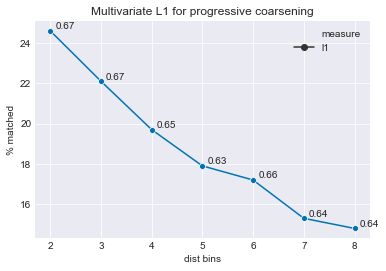

In [13]:
relaxed.plot()

## L1 for depth=0 and one-to-many

In [14]:
# Multivariate imbalance
post = cem.imbalance(coarsening)
print(f'Pre-coarsening L1 imbalance: {round(cem.preimbalance,2)}\nPost-coarsening L1 imbalance: {round(post,2)}')

Pre-coarsening L1 imbalance: 0.89
Post-coarsening L1 imbalance: 0.65


In [15]:
# Univariate imbalance
uni = cem.univariate_imbalance(coarsening, measure='l1')
uni.summary

,imbalance,measure,statistic,type,P>|z|,0%,25%,50%,75%,100%
dist,0.069012,l1,1.194945,diff,1.426415e-02,1.0,0.0,1.0,2.0,0.0
year,0.049375,l1,0.348466,diff,1.918591e-01,0.0,1.0,0.0,1.0,0.0
seasons,0.064321,l1,0.074197,diff,7.125707e-01,0.0,1.0,1.0,0.0,-3.0
temperature,0.110035,l1,-2.296514,diff,6.219876e-07,9.0,-4.0,-2.0,0.0,0.0
wind,0.151504,l1,-0.575058,diff,7.588086e-04,0.0,0.0,-1.0,-2.0,-1.0
away_game,0.074567,l1,0.000775,Chi2,9.777897e-01,NaN,NaN,NaN,NaN,NaN
postseason,0.018676,l1,0.079599,Chi2,7.778412e-01,NaN,NaN,NaN,NaN,NaN
iced,0.063275,l1,0.176207,Chi2,6.746533e-01,NaN,NaN,NaN,NaN,NaN
turf,0.000000,l1,0.000000,Chi2,NaN,NaN,NaN,NaN,NaN,NaN
precipitation,0.002385,l1,0.000792,Chi2,9.775428e-01,NaN,NaN,NaN,NaN,NaN


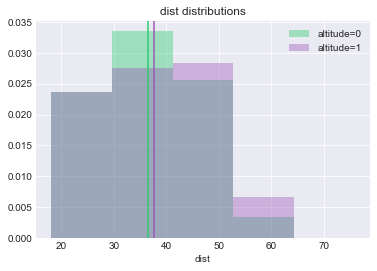

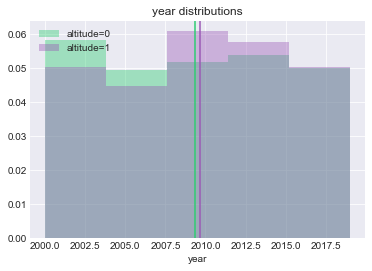

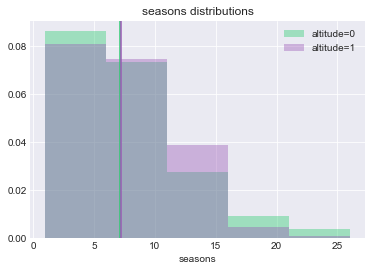

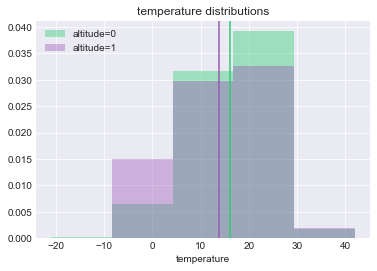

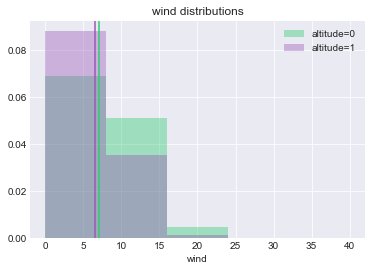

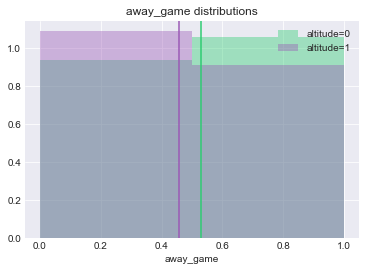

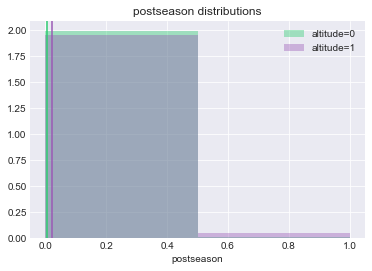

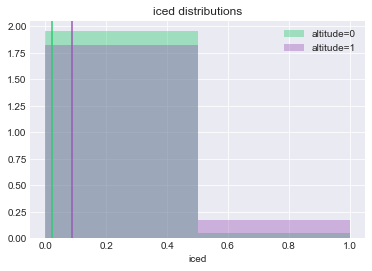

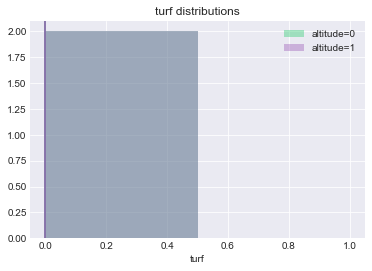

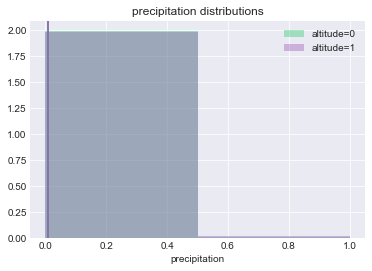

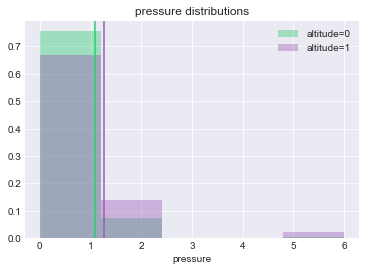

In [16]:
uni.plot(kde=False)

## Weighted log-linear regression at different coarsenings

Distance is the most important covariate, so we will perform CEM for different level of distance coarsening and regress on the weighted results. We plot the evolution of the regression coefficients for each binning on distance.

In [11]:
coarsening = {
    'dist': {'bins': 4, 'cut': 'cut'}, # relax over
    'year': {'bins': 5, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'}, # quantiles
    'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'}, #quantiles
    'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
    'pressure': {'bins': [-1,1,4,6], 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening.pop(T)
coarsening

{'dist': {'bins': 4, 'cut': 'cut'},
 'year': {'bins': 5, 'cut': 'cut'},
 'seasons': {'bins': [0, 0.25, 0.75, 1], 'cut': 'qcut'},
 'temperature': {'bins': [0, 0.05, 0.5, 0.95, 1], 'cut': 'qcut'},
 'wind': {'bins': [-1, 6, 18, 41], 'cut': 'cut'},
 'pressure': {'bins': [-1, 1, 4, 6], 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

In [16]:
#model
relax_on = [('dist', range(2,9), 'cut'),]
formula = 'good ~ ' + ' + '.join(df.drop(['good']+drop, axis=1).columns) + f' + dist*{T}'
regressed = cem.regress(coarsening, relax_on, formula=formula, drop=drop)

0%|          | 0/7 [00:00<?, ?it/s]Regressing with 7 different pd.cut binnings on "dist"

100%|██████████| 7/7 [01:03<00:00,  9.12s/it]


In [17]:
regressed.summary

,result,imbalance,vc,coarsening,var
n_bins,,,,,
2,<statsmodels.genmod.generalized_linear_model.G...,0.642842,"0 3469 1 547 Name: altitude, dtype: int64","{'dist': {'bins': 2, 'cut': 'cut', 'method': '...",dist
3,<statsmodels.genmod.generalized_linear_model.G...,0.623432,"0 3088 1 519 Name: altitude, dtype: int64","{'dist': {'bins': 3, 'cut': 'cut', 'method': '...",dist
4,<statsmodels.genmod.generalized_linear_model.G...,0.598492,"0 2627 1 509 Name: altitude, dtype: int64","{'dist': {'bins': 4, 'cut': 'cut', 'method': '...",dist
5,<statsmodels.genmod.generalized_linear_model.G...,0.564272,"0 2432 1 491 Name: altitude, dtype: int64","{'dist': {'bins': 5, 'cut': 'cut', 'method': '...",dist
6,<statsmodels.genmod.generalized_linear_model.G...,0.602144,"0 2263 1 484 Name: altitude, dtype: int64","{'dist': {'bins': 6, 'cut': 'cut', 'method': '...",dist
7,<statsmodels.genmod.generalized_linear_model.G...,0.573514,"0 1995 1 470 Name: altitude, dtype: int64","{'dist': {'bins': 7, 'cut': 'cut', 'method': '...",dist
8,<statsmodels.genmod.generalized_linear_model.G...,0.579495,"0 1888 1 466 Name: altitude, dtype: int64","{'dist': {'bins': 8, 'cut': 'cut', 'method': '...",dist


In [18]:
regressed.coarsenings()

,imbalance,observations,treatment_0,treatment_1
n_bins,,,,
2,0.642842,4016.0,3469.0,547.0
3,0.623432,3607.0,3088.0,519.0
4,0.598492,3136.0,2627.0,509.0
5,0.564272,2923.0,2432.0,491.0
6,0.602144,2747.0,2263.0,484.0
7,0.573514,2465.0,1995.0,470.0
8,0.579495,2354.0,1888.0,466.0


In [19]:
regressed.covariates().loc[[T,f'dist:{T}'], :]

,,,coef,std err,z,P>|z|,[0.025,0.975]
covariate,n_bins,var,,,,,,
altitude,2,dist,-1.2255,0.675,-1.815,0.070,-2.549,0.098
dist:altitude,2,dist,0.0398,0.015,2.605,0.009,0.010,0.070
altitude,3,dist,0.5030,0.929,0.542,0.588,-1.318,2.324
dist:altitude,3,dist,0.0026,0.020,0.130,0.897,-0.037,0.043
altitude,4,dist,1.6125,0.923,1.746,0.081,-0.197,3.422
dist:altitude,4,dist,-0.0276,0.020,-1.390,0.165,-0.067,0.011
altitude,5,dist,0.0386,0.864,0.045,0.964,-1.654,1.731
dist:altitude,5,dist,0.0083,0.019,0.433,0.665,-0.029,0.046
altitude,6,dist,0.9945,0.908,1.095,0.273,-0.786,2.775


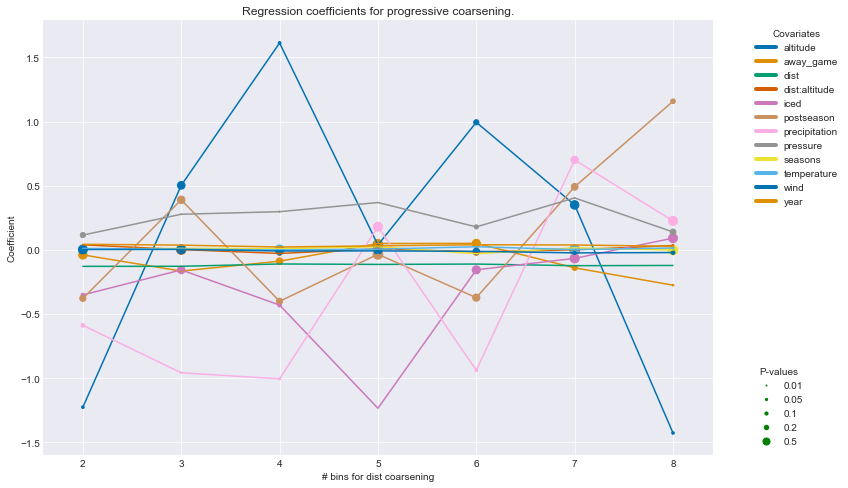

In [20]:
regressed.plot(stars=False)

## Weighted difference of means (altitude: for short, medium and long and all-combined groups)

In [ ]:
from matching.cem import LSATT
weights = CEM.match(df.drop('good', axis=1), T, bins)
lsatt = LSATT(df, T, 'good', weights)
print(lsatt)

## k-k log-linear regression at different coarsenings

## k-k difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## k-k Bayesian difference of means at different coarsenings (altitude: for short, medium and long and all-combined groups)

## Model - BOGUS: This kind of modelling doesn't take into account stratum sizes. Will need to weight them if you want to use it.

We work within a Bayesian framework, setting a prior distribution on the true population proportion and update the prior after our observations. The Beta-Binomial conjugacy makes this process relatively pain-free. Our prior mean is the sample population proportion (all kicks).

In [ ]:
# dist_level = (df_matched['dist']>=40) & (df_matched['dist']<50)
dist_level = (df_matched['dist']>=45)
print(len(df_matched.loc[(df_matched[on]==1) & dist_level, :]), on, len(df_matched.loc[(df_matched[on]==0) & dist_level, :]), f'not {on}.')

In [ ]:
from scipy.stats import beta
p_hat = df_matched.loc[dist_level, 'good'].mean()
alpha_ = 10
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

In [ ]:
from util.bayes import BetaBinomial

control = BetaBinomial(alpha_, beta_, f'not {on}')
treatment = BetaBinomial(alpha_, beta_, on)
control.plot_prior(show=True)
plt.cla()

control.observe(df_matched.loc[(df_matched[on]==0) & dist_level, 'good'])
treatment.observe(df_matched.loc[(df_matched[on]==1) & dist_level, 'good'])

control.plot_posterior(prior=False)
treatment.plot_posterior(show=True, prior=True)

# zoom in
x = np.linspace(0.5,0.9,500)
control.plot_posterior(x, prior=False, show=False)
treatment.plot_posterior(x, prior=False, show=True)

samples = 20000
samples_posterior_c = control.sample(samples)
samples_posterior_t = treatment.sample(samples)

In [ ]:
posterior_diff = samples_posterior_t - samples_posterior_c

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
gt = int((samples_posterior_t>samples_posterior_c).mean()*100)
print(f'{gt}% likely that {on} has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
alpha = 0.5
center, _, _ = bayes_mvs(posterior_diff, alpha=alpha)
print(f'{round(center.statistic,2)} is the median difference, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment over control using our posterior distributions.

In [ ]:
posterior_relative = (samples_posterior_t-samples_posterior_c)/samples_posterior_c
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title(f'Posterior distribution of relative lift for {on} kicks over not-{on} kicks.')
print(int((posterior_relative>0.05).mean()*100), r'% likely relative lift is greater than 5%.')

alpha = 0.5
center, _, _ = bayes_mvs(posterior_relative, alpha=alpha)
print(f'{round(center.statistic,2)} is the median relative lift, with {int(alpha*100)}% credible interval of ({round(center.statistic-center.minmax[0],2)},{round(center.statistic+center.minmax[-1],2)}).')